In [1]:
import re

import pandas as pd
import numpy as np

import shap
shap.initjs()

from catboost import CatBoostClassifier, Pool

In [2]:
raw_train_data = pd.read_csv('tabular-playground-series-mar-2021/train.csv')
test_data = pd.read_csv('tabular-playground-series-mar-2021/test.csv')

In [3]:
raw_train_data.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [4]:
raw_train_data.describe()

,id,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,250183.425697,0.504749,0.494073,0.516632,0.474235,0.504848,0.502257,0.488229,0.501739,0.488074,0.469496,0.508230,0.264870
std,144320.334812,0.206788,0.213037,0.214851,0.216636,0.227474,0.241243,0.211335,0.203496,0.179048,0.194516,0.203393,0.441265
min,0.000000,-0.049562,0.084480,0.094493,-0.045316,0.168071,-0.036379,0.005199,0.090901,0.024139,0.214866,0.097789,0.000000
25%,125399.750000,0.344985,0.317363,0.326047,0.292249,0.279303,0.276442,0.323914,0.353054,0.358915,0.309934,0.368312,0.000000
50%,250192.500000,0.479650,0.463170,0.471247,0.387564,0.479858,0.554768,0.518089,0.435404,0.410908,0.407477,0.446576,0.000000
75%,375246.250000,0.637657,0.693992,0.704625,0.644950,0.725779,0.735225,0.608537,0.642023,0.612725,0.586793,0.581957,1.000000
max,499999.000000,1.004559,1.009958,1.016600,0.952187,0.858578,0.853022,0.966553,1.035818,1.055885,1.005652,1.011331,1.000000


<AxesSubplot:>

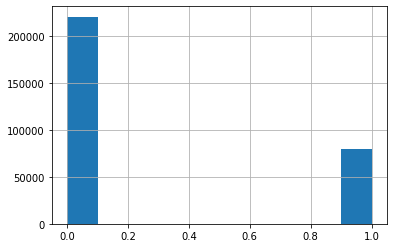

In [5]:
raw_train_data['target'].hist()

In [6]:
train_data = raw_train_data.drop('target', axis=1)
train_data.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
0,0,A,I,A,B,B,BI,A,S,Q,...,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915
1,1,A,I,A,A,E,BI,K,W,AD,...,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729
2,2,A,K,A,A,E,BI,A,E,BM,...,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452
3,3,A,K,A,C,E,BI,A,Y,AD,...,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242
4,4,A,I,G,B,E,BI,C,G,Q,...,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960


In [7]:
features = train_data.columns

categorical_features = []

for feature in features:
    if re.match(r"cat", feature):
        categorical_features.append(feature)

continuous_features = []

for feature in features:
    if re.match(r"cont", feature):
        continuous_features.append(feature)

In [8]:
train_labels = raw_train_data[['target']]
train_labels.head()

,target
0,0
1,0
2,0
3,0
4,1


In [9]:
train_pool = Pool(train_data, 
                  train_labels, cat_features=categorical_features)

In [10]:
test_pool = Pool(test_data, cat_features=categorical_features)

In [11]:
params = {"iterations": 100,
          "depth": 2,
          "loss_function": "Logloss",
          "verbose": False,
          "roc_file": "roc-file"}

In [12]:
model = CatBoostClassifier()
#train the model
model.fit(train_pool)

Learning rate set to 0.11767
0:	learn: 0.6159062	total: 327ms	remaining: 5m 26s
1:	learn: 0.5593461	total: 579ms	remaining: 4m 48s
2:	learn: 0.5155275	total: 829ms	remaining: 4m 35s
3:	learn: 0.4836117	total: 1.02s	remaining: 4m 13s
4:	learn: 0.4593391	total: 1.26s	remaining: 4m 10s
5:	learn: 0.4408935	total: 1.53s	remaining: 4m 14s
6:	learn: 0.4272526	total: 1.75s	remaining: 4m 8s
7:	learn: 0.4168604	total: 2.03s	remaining: 4m 12s
8:	learn: 0.4088667	total: 2.23s	remaining: 4m 5s
9:	learn: 0.4023244	total: 2.46s	remaining: 4m 3s
10:	learn: 0.3964691	total: 2.69s	remaining: 4m 2s
11:	learn: 0.3918415	total: 2.94s	remaining: 4m 1s
12:	learn: 0.3879882	total: 3.19s	remaining: 4m 2s
13:	learn: 0.3847712	total: 3.44s	remaining: 4m 2s
14:	learn: 0.3817900	total: 3.67s	remaining: 4m
15:	learn: 0.3796634	total: 3.9s	remaining: 3m 59s
16:	learn: 0.3774954	total: 4.16s	remaining: 4m
17:	learn: 0.3754758	total: 4.42s	remaining: 4m 1s
18:	learn: 0.3738440	total: 4.68s	remaining: 4m 1s
19:	learn: 

158:	learn: 0.3468371	total: 42.3s	remaining: 3m 43s
159:	learn: 0.3467470	total: 42.6s	remaining: 3m 43s
160:	learn: 0.3466954	total: 43s	remaining: 3m 43s
161:	learn: 0.3466543	total: 43.2s	remaining: 3m 43s
162:	learn: 0.3466024	total: 43.5s	remaining: 3m 43s
163:	learn: 0.3465429	total: 43.7s	remaining: 3m 42s
164:	learn: 0.3464648	total: 44s	remaining: 3m 42s
165:	learn: 0.3464008	total: 44.3s	remaining: 3m 42s
166:	learn: 0.3463222	total: 44.6s	remaining: 3m 42s
167:	learn: 0.3462676	total: 45s	remaining: 3m 42s
168:	learn: 0.3462010	total: 45.3s	remaining: 3m 42s
169:	learn: 0.3461325	total: 45.6s	remaining: 3m 42s
170:	learn: 0.3460824	total: 45.8s	remaining: 3m 42s
171:	learn: 0.3460094	total: 46.1s	remaining: 3m 42s
172:	learn: 0.3459290	total: 46.4s	remaining: 3m 41s
173:	learn: 0.3458695	total: 46.7s	remaining: 3m 41s
174:	learn: 0.3458193	total: 47.1s	remaining: 3m 41s
175:	learn: 0.3457720	total: 47.4s	remaining: 3m 41s
176:	learn: 0.3456999	total: 47.7s	remaining: 3m 41s

312:	learn: 0.3388749	total: 1m 26s	remaining: 3m 10s
313:	learn: 0.3388446	total: 1m 27s	remaining: 3m 10s
314:	learn: 0.3387989	total: 1m 27s	remaining: 3m 10s
315:	learn: 0.3387541	total: 1m 27s	remaining: 3m 10s
316:	learn: 0.3387077	total: 1m 28s	remaining: 3m 9s
317:	learn: 0.3386917	total: 1m 28s	remaining: 3m 9s
318:	learn: 0.3386348	total: 1m 28s	remaining: 3m 9s
319:	learn: 0.3385974	total: 1m 29s	remaining: 3m 9s
320:	learn: 0.3385463	total: 1m 29s	remaining: 3m 9s
321:	learn: 0.3384929	total: 1m 29s	remaining: 3m 9s
322:	learn: 0.3384487	total: 1m 30s	remaining: 3m 9s
323:	learn: 0.3384383	total: 1m 30s	remaining: 3m 9s
324:	learn: 0.3384124	total: 1m 31s	remaining: 3m 9s
325:	learn: 0.3383698	total: 1m 31s	remaining: 3m 8s
326:	learn: 0.3383215	total: 1m 31s	remaining: 3m 8s
327:	learn: 0.3382653	total: 1m 31s	remaining: 3m 8s
328:	learn: 0.3382381	total: 1m 32s	remaining: 3m 8s
329:	learn: 0.3381843	total: 1m 32s	remaining: 3m 7s
330:	learn: 0.3381464	total: 1m 32s	remain

466:	learn: 0.3336432	total: 2m 12s	remaining: 2m 31s
467:	learn: 0.3336044	total: 2m 12s	remaining: 2m 31s
468:	learn: 0.3335644	total: 2m 13s	remaining: 2m 30s
469:	learn: 0.3335439	total: 2m 13s	remaining: 2m 30s
470:	learn: 0.3335077	total: 2m 13s	remaining: 2m 30s
471:	learn: 0.3334623	total: 2m 13s	remaining: 2m 29s
472:	learn: 0.3334420	total: 2m 14s	remaining: 2m 29s
473:	learn: 0.3333933	total: 2m 14s	remaining: 2m 29s
474:	learn: 0.3333612	total: 2m 14s	remaining: 2m 28s
475:	learn: 0.3333521	total: 2m 15s	remaining: 2m 28s
476:	learn: 0.3333346	total: 2m 15s	remaining: 2m 28s
477:	learn: 0.3333082	total: 2m 15s	remaining: 2m 28s
478:	learn: 0.3332855	total: 2m 15s	remaining: 2m 27s
479:	learn: 0.3332487	total: 2m 16s	remaining: 2m 27s
480:	learn: 0.3332043	total: 2m 16s	remaining: 2m 27s
481:	learn: 0.3331758	total: 2m 16s	remaining: 2m 26s
482:	learn: 0.3331587	total: 2m 16s	remaining: 2m 26s
483:	learn: 0.3331256	total: 2m 17s	remaining: 2m 26s
484:	learn: 0.3330866	total:

619:	learn: 0.3294689	total: 2m 53s	remaining: 1m 46s
620:	learn: 0.3294491	total: 2m 54s	remaining: 1m 46s
621:	learn: 0.3294158	total: 2m 54s	remaining: 1m 46s
622:	learn: 0.3293786	total: 2m 54s	remaining: 1m 45s
623:	learn: 0.3293404	total: 2m 55s	remaining: 1m 45s
624:	learn: 0.3293254	total: 2m 55s	remaining: 1m 45s
625:	learn: 0.3293013	total: 2m 55s	remaining: 1m 44s
626:	learn: 0.3292888	total: 2m 55s	remaining: 1m 44s
627:	learn: 0.3292482	total: 2m 56s	remaining: 1m 44s
628:	learn: 0.3292423	total: 2m 56s	remaining: 1m 44s
629:	learn: 0.3292157	total: 2m 56s	remaining: 1m 43s
630:	learn: 0.3291942	total: 2m 56s	remaining: 1m 43s
631:	learn: 0.3291651	total: 2m 57s	remaining: 1m 43s
632:	learn: 0.3291253	total: 2m 57s	remaining: 1m 42s
633:	learn: 0.3290851	total: 2m 57s	remaining: 1m 42s
634:	learn: 0.3290583	total: 2m 57s	remaining: 1m 42s
635:	learn: 0.3290237	total: 2m 58s	remaining: 1m 41s
636:	learn: 0.3289955	total: 2m 58s	remaining: 1m 41s
637:	learn: 0.3289607	total:

773:	learn: 0.3257657	total: 3m 35s	remaining: 1m 2s
774:	learn: 0.3257598	total: 3m 35s	remaining: 1m 2s
775:	learn: 0.3257384	total: 3m 35s	remaining: 1m 2s
776:	learn: 0.3256974	total: 3m 36s	remaining: 1m 2s
777:	learn: 0.3256605	total: 3m 36s	remaining: 1m 1s
778:	learn: 0.3256509	total: 3m 36s	remaining: 1m 1s
779:	learn: 0.3256249	total: 3m 37s	remaining: 1m 1s
780:	learn: 0.3255921	total: 3m 37s	remaining: 1m
781:	learn: 0.3255556	total: 3m 37s	remaining: 1m
782:	learn: 0.3255230	total: 3m 37s	remaining: 1m
783:	learn: 0.3255040	total: 3m 38s	remaining: 1m
784:	learn: 0.3254669	total: 3m 38s	remaining: 59.8s
785:	learn: 0.3254337	total: 3m 38s	remaining: 59.5s
786:	learn: 0.3254143	total: 3m 38s	remaining: 59.3s
787:	learn: 0.3253813	total: 3m 39s	remaining: 59s
788:	learn: 0.3253552	total: 3m 39s	remaining: 58.7s
789:	learn: 0.3253371	total: 3m 39s	remaining: 58.4s
790:	learn: 0.3253193	total: 3m 39s	remaining: 58.1s
791:	learn: 0.3252812	total: 3m 40s	remaining: 57.9s
792:	le

930:	learn: 0.3221012	total: 4m 17s	remaining: 19.1s
931:	learn: 0.3220736	total: 4m 17s	remaining: 18.8s
932:	learn: 0.3220622	total: 4m 18s	remaining: 18.5s
933:	learn: 0.3220409	total: 4m 18s	remaining: 18.3s
934:	learn: 0.3220300	total: 4m 18s	remaining: 18s
935:	learn: 0.3220030	total: 4m 18s	remaining: 17.7s
936:	learn: 0.3220023	total: 4m 19s	remaining: 17.4s
937:	learn: 0.3219768	total: 4m 19s	remaining: 17.2s
938:	learn: 0.3219471	total: 4m 19s	remaining: 16.9s
939:	learn: 0.3219213	total: 4m 20s	remaining: 16.6s
940:	learn: 0.3219071	total: 4m 20s	remaining: 16.3s
941:	learn: 0.3218782	total: 4m 20s	remaining: 16s
942:	learn: 0.3218447	total: 4m 20s	remaining: 15.8s
943:	learn: 0.3218081	total: 4m 21s	remaining: 15.5s
944:	learn: 0.3217806	total: 4m 21s	remaining: 15.2s
945:	learn: 0.3217485	total: 4m 21s	remaining: 14.9s
946:	learn: 0.3217096	total: 4m 21s	remaining: 14.7s
947:	learn: 0.3216945	total: 4m 22s	remaining: 14.4s
948:	learn: 0.3216570	total: 4m 22s	remaining: 14.

In [14]:
preds_class = model.predict(test_pool, prediction_type='Class')
preds_proba = model.predict(test_pool, prediction_type='Probability')

In [15]:
 test_data['target'] = [preds_proba[i][1] for i in range(len(preds_proba))]

In [16]:
test_data[['id', 'target']].head()

,id,target
0,5,0.147644
1,6,0.349056
2,8,0.015901
3,9,0.152418
4,11,0.081235


In [ ]:
#test_data[['id', 'target']].to_csv('sub1.csv', index=False)

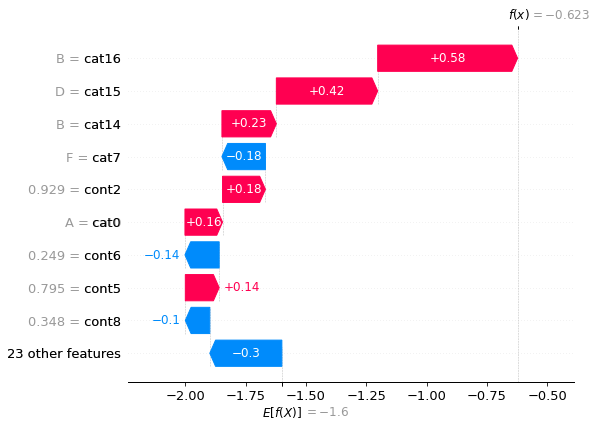

In [62]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.TreeExplainer(model)
shap_values = explainer(test_data)

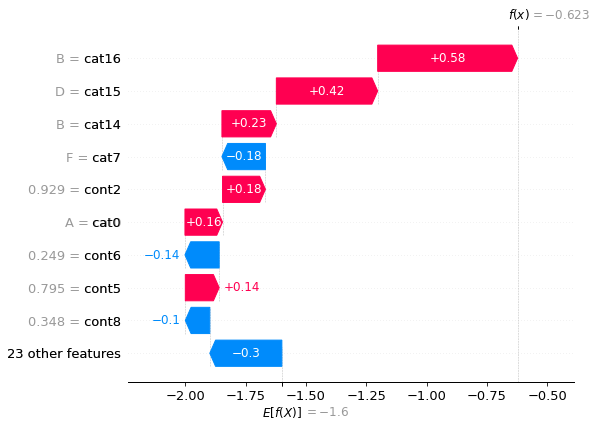

In [63]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[1])

In [64]:
# visualize the first prediction's explanation with a force plot
shap.force_plot(explainer.expected_value, shap_values)

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
shap.plots.bar(shap_values)